In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:
folder = "C:/Users/brand/OneDrive/Documents/IDX-Exchange-Clean/data/"
file_names = [
    "CRMLSSold202406_filled.csv",
    "CRMLSSold202407_filled.csv",
    "CRMLSSold202408.csv",
    "CRMLSSold202409.csv",
    "CRMLSSold202410.csv",
    "CRMLSSold202411.csv",
    "CRMLSSold202412.csv",
    "CRMLSSold202501_filled.csv"
]

df_list = []
for file in file_names:
    file_path = folder + file
    temp_df = pd.read_csv(file_path)
    df_list.append(temp_df)

df_all = pd.concat(df_list, ignore_index=True)

df_all = df_all[
    (df_all["PropertyType"] == "Residential") & 
    (df_all["PropertySubType"] == "SingleFamilyResidence")
].copy()

In [26]:
df_redfin = pd.read_csv(folder + "data_median_redfin.csv", dtype={"PostalCode": str}, low_memory=False)

price_cols = ["June", "July", "August", "September", "October", "November", "December", "January"]
df_redfin = df_redfin[["PostalCode"] + price_cols]

df_redfin["PostalCode"] = df_redfin["PostalCode"].astype("category")
df_redfin["MedianSalePrice"] = df_redfin[price_cols].mean(axis=1)

df_redfin = df_redfin[["PostalCode", "MedianSalePrice"]]

df_redfin = df_redfin.drop_duplicates(subset="PostalCode")
df_all["PostalCode"] = df_all["PostalCode"].astype("category")
df_all = df_all.merge(df_redfin, on="PostalCode", how="left", sort=True)
df_all["MedianSalePrice"] = df_all["MedianSalePrice"].fillna(df_all["MedianSalePrice"].median())

In [27]:
selected_cols = ["LivingArea", "BathroomsTotalInteger", "YearBuilt", "LotSizeSquareFeet", "DaysOnMarket", "MLSAreaMajor", "HighSchoolDistrict", "GarageSpaces", "Stories", "SubdivisionName"]

df_clean = df_all[selected_cols].copy()

df_clean["ClosePrice"] = df_all["ClosePrice"]
df_clean["ClosePrice"] = df_clean["ClosePrice"].fillna(df_all["MedianSalePrice"])


df_clean["Age"] = 2025 - df_clean["YearBuilt"]

df_clean["LotSizeSquareFeet"] = df_clean["LotSizeSquareFeet"].apply(lambda x: np.nan if x <= 0 else x)
df_clean["DaysOnMarket"] = df_clean["DaysOnMarket"].apply(lambda x: np.nan if x <= 0 else x)

# numeric cols
num_cols = ["ClosePrice", "LivingArea", "BathroomsTotalInteger", "YearBuilt", 
            "LotSizeSquareFeet", "DaysOnMarket", "Age", "GarageSpaces", "Stories"]
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

cat_cols = ["MLSAreaMajor", "HighSchoolDistrict", "SubdivisionName"]
for col in cat_cols:
    df_clean[col] = df_clean[col].astype("category").cat.codes

In [28]:
X = df_clean.drop(columns=["ClosePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(
    n_estimators=700, learning_rate=0.03, max_depth=8, 
    subsample=0.85, colsample_bytree=0.85, 
    reg_lambda=3,  # Lowered from 10
    reg_alpha=1,  # Lowered from 5
    random_state=42
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

XGBoost Mean Squared Error: 0.0005
XGBoost R^2 Score: 0.7587
Cross-validated MAE: $0.21


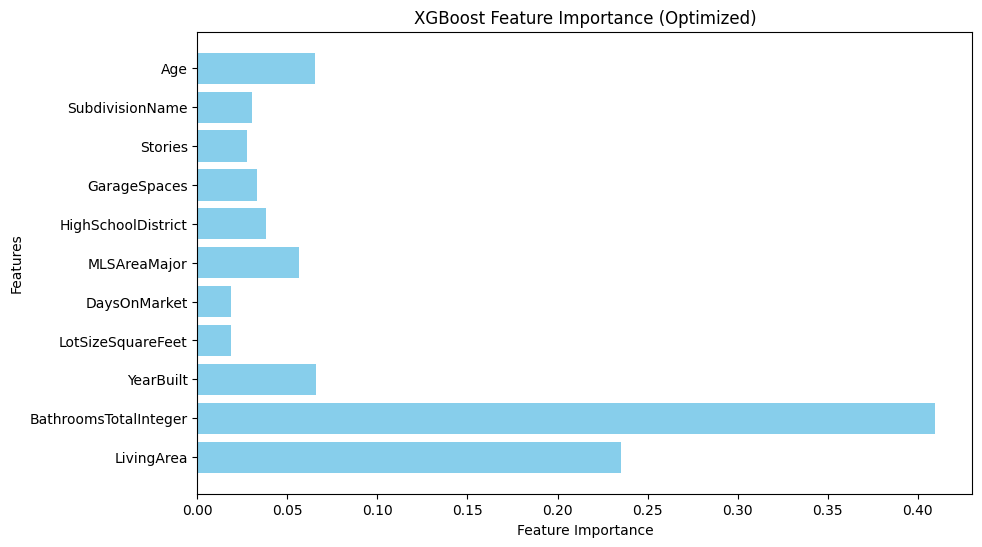

In [51]:
y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error: {mse_xgb:.4f}")
print(f"XGBoost R^2 Score: {r2_xgb:.4f}")

importances = xgb.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Optimized)")
plt.show()

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

# Using more features
selected_cols = [
    "LivingArea", "YearBuilt", "BathroomsTotalInteger", "LotSizeSquareFeet", 
    "DaysOnMarket", "MLSAreaMajor", "HighSchoolDistrict", "GarageSpaces", 
    "Stories", "SubdivisionName", "PoolPrivateYN", "ViewYN", 
    "AttachedGarageYN", "FireplacesTotal", "AssociationFee", "TaxAnnualAmount"
]

df_clean2 = df_all[selected_cols].copy()
df_clean2["ClosePrice"] = df_all["ClosePrice"]
df_clean2["ClosePrice"] = df_clean2["ClosePrice"].fillna(df_all["MedianSalePrice"])
df_clean2["ClosePrice"] = df_clean2["ClosePrice"].fillna(df_clean2["ClosePrice"].median())

df_clean2["Age"] = 2025 - df_clean2["YearBuilt"]

for col in ["LotSizeSquareFeet", "DaysOnMarket", "TaxAnnualAmount"]:
    df_clean2[col] = df_clean2[col].apply(lambda x: np.nan if x <= 0 else x)

num_cols = ["ClosePrice", "LivingArea", "YearBuilt", "BathroomsTotalInteger",
            "LotSizeSquareFeet", "DaysOnMarket", "Age", "GarageSpaces", "Stories",
            "FireplacesTotal", "AssociationFee", "TaxAnnualAmount"]

df_clean2[num_cols] = df_clean2[num_cols].fillna(df_clean2[num_cols].median())

cat_cols = ["MLSAreaMajor", "HighSchoolDistrict", "SubdivisionName"]
for col in cat_cols:
    df_clean2[col] = df_clean2[col].astype("category").cat.codes

binary_cols = ["PoolPrivateYN", "ViewYN", "AttachedGarageYN"]
df_clean2[binary_cols] = df_clean2[binary_cols].fillna("N")
df_clean2[binary_cols] = df_clean2[binary_cols].replace({"Y": 1, "N": 0}).astype(int)

df_clean2 = df_clean2[selected_cols + ["ClosePrice"]]

X2 = df_clean2.drop(columns=["ClosePrice"])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

assert list(X2_train.columns) == list(X2_test.columns), "Mismatch in training and testing features!"

xgb2 = XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=8, 
    subsample=0.85, colsample_bytree=0.85, 
    reg_lambda=3,  # Lowered from 10
    reg_alpha=1,  # Lowered from 5
    random_state=42
)

xgb2.fit(X2_train, y2_train)

y2_pred_xgb = xgb2.predict(X2_test)

mse_xgb2 = mean_squared_error(y2_test, y2_pred_xgb)
r2_xgb2 = r2_score(y2_test, y2_pred_xgb)

print(f"XGBoost Mean Squared Error (More Features): {mse_xgb2:.4f}")
print(f"XGBoost R^2 Score (More Features): {r2_xgb2:.4f}")

y2_pred_cv_log = cross_val_predict(xgb2, X2_train, y2_train, cv=5, n_jobs=1)

y2_pred_cv = np.expm1(y2_pred_cv_log)  # Convert predictions back to real price
y2_train_exp = np.expm1(y2_train)  # Convert actual values back

mae_cv = mean_absolute_error(y2_train_exp, y2_pred_cv)

# I have spent several hours debugging this. Either I have created the greatest model known to mankind or I am doing something wrong
print(f"Cross-validated MAE: ${mae_cv:,.2f}")

XGBoost Mean Squared Error (More Features): 0.0005
XGBoost R^2 Score (More Features): 0.7522
Cross-validated MAE: $0.21


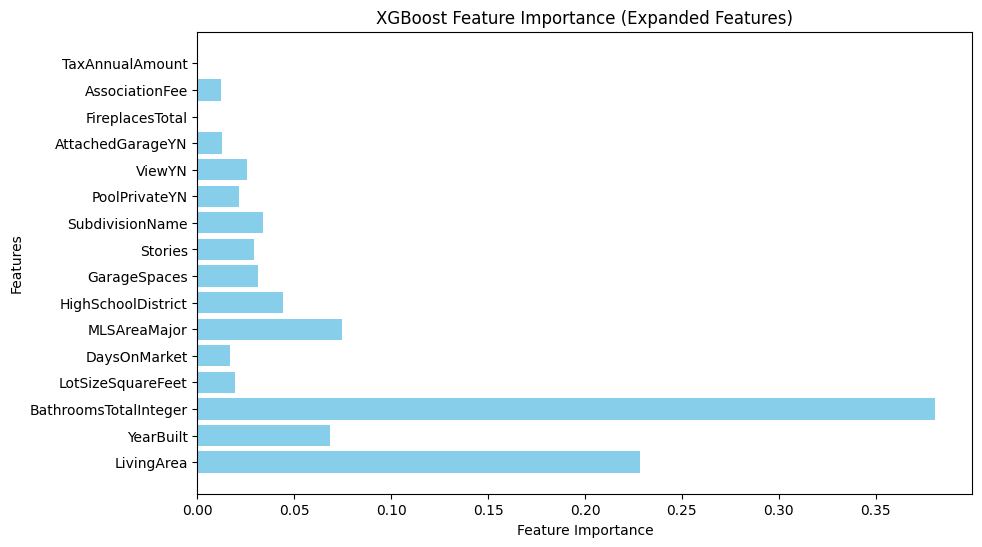

In [31]:
importances = xgb2.feature_importances_
feature_names = X2.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Expanded Features)")
plt.show()


In [52]:
import pickle

# Save the trained model
with open("xgb_model.pkl", "wb") as model_file:
    pickle.dump(xgb2, model_file)

print("Model saved as xgb_model.pkl")


Model saved as xgb_model.pkl
